# fbprophet 모델을 활용한 인공지능 비트 트레이더 경진대회 베이스라인 코드

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [3]:
!pip install statsmodels==0.11.1
!pip install fbprophet

  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.0
    Uninstalling statsmodels-0.12.0:
      Successfully uninstalled statsmodels-0.12.0
  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached convertdate-2.3.2-py3-none-any.whl (47 kB)
  Using cached holidays-0.10.5.2.tar.gz (121 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
  Using cached PyMeeus-0.5.11.tar.gz (5.4 MB)
  Using cached korean_lunar_calendar-0.2.1-py3-none-any.whl (8.0 kB)
  Using cached hijri_converter-2.1.1-py3-none-any.whl (14 kB)
  Running setup.py clean for fbprophet
  Created wheel for holidays: filename=holidays-0.10.5.2-py3-none-any.whl size=126818 sha256=903bdc0039ec420b12c4fc58b85053f1cca8b7cd2f9bc6264896a85ee6597e36
  Stored in directory: c:\users\choi\appdata\local\pip\cache\wheels\6a\cf\7a\3ffc6ba5930fd024335b4a12b0be8bc3ba5a8f

  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\Choi\anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Choi\\AppData\\Local\\Temp\\pip-install-23ycq8ke\\fbprophet\\setup.py'"'"'; __file__='"'"'C:\\Users\\Choi\\AppData\\Local\\Temp\\pip-install-23ycq8ke\\fbprophet\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\Choi\AppData\Local\Temp\pip-wheel-6bt0t1hj'
       cwd: C:\Users\Choi\AppData\Local\Temp\pip-install-23ycq8ke\fbprophet\
  Complete output (44 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib
  creating build\lib\fbprophet
  creating build\lib\fbprophet\stan_model
  Traceback (most recent call last):
    File "<string>", line 1, in <module>
    File "C:\Users\Choi\AppData\Local\Temp\pip-install-23ycq8ke\fbprophe


Failed to build fbprophet
    Running setup.py install for fbprophet: started
    Running setup.py install for fbprophet: finished with status 'error'


# 1. Library Import

In [16]:
import numpy as np
import pandas as pd
import gc
import math
import os.path
import time
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet
import warnings
import datetime
warnings.filterwarnings("ignore")

변수 선언

In [20]:
U = 0 
count_u = 0
D = 0
count_D = 0
judge_UorD = 0

# 2. 데이터 불러오기

## 1) read_csv

In [7]:
train_x_df = pd.read_csv(r'C:\Users\Choi\Desktop\abc\train_x_df.csv')
train_y_df = pd.read_csv(r"C:\Users\Choi\Desktop\abc\train_y_df.csv")
test_x_df = pd.read_csv(r"C:\Users\Choi\Desktop\abc\test_x_df.csv")

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000


In [55]:
train_x_df['average'] = (train_x_df['open'] - train_x_df['close']) / 2
count_u = 0
count_d = 0

for sample_id_value in range(0, 760, 1):
    #1380분 / 10분
    for total_count in range(0, 69, 1):
        #10분으로 나눠서 10까지만.
        for ten_minute in range(0, 20, 1):
        
            judge_UorD = total_count * 10 + ten_minute + sample_id_value * 1380
            # 전날 값이 더 작다면 U에다가 더해줌
            if train_x_df['average'][judge_UorD] < train_x_df['average'][judge_UorD + 1]:
            
                U = U + (train_x_df['average'][judge_UorD] - train_x_df['average'][judge_UorD+1])
                count_u = count_u + 1

            #전날 값이 더 크다면 D에다가 더해줌    
            elif train_x_df['average'][judge_UorD] > train_x_df['average'][judge_UorD + 1]:
                D = D + (train_x_df['average'][judge_UorD+1] - train_x_df['average'][judge_UorD])
                count_d = count_d + 1

            else:
                pass

        AU = U / count_u
        AD = D / count_d
        RS = AU/AD
        RSI = RS/(1+RS)
        
        coin_value = judge_UorD // 1380
        timing = judge_UorD % 1380
    
#        if RSI > 0.50:
 #           print(coin_value," 번 코인", timing, "초과매수, 매도포지션")

#        if RSI < 0.5:
 #           print(coin_value," 번 코인", timing, "초과매도, 매수포지션")

## 2) numpy arrary로 변환하기

In [48]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [4]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [6]:
print(f'''
train_x_array {train_x_array.shape}
train_y_array {train_y_array.shape}
test_x_array {test_x_array.shape}
''')


train_x_array (7362, 1380, 10)
train_y_array (7362, 120, 10)
test_x_array (529, 1380, 10)



## 3) 샘플 확인하기

In [7]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

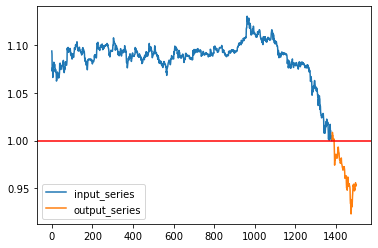

In [8]:
# sample_id 1012에 해당하는 sample의 분단위 시가 변동 정보 시각화
idx = 1012
plot_series(train_x_array[idx,:,1], train_y_array[idx,:,1])
plt.show()

# 3. 모델 훈련하기

## 1) train 샘플 훈련하기

In [9]:
start_time = '2021-01-31 00:00:00'
start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')

In [10]:
idx = 1121
# train data 중 sample_id 1121에 해당하는 x_series로 arima 모델을 학습한 후
# y_sereis를 추론
x_series = train_x_array[idx,:,1]
y_series = train_y_array[idx,:,1]

In [11]:
x_df = pd.DataFrame()
x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
x_df['y'] = x_series.tolist()

In [12]:
x_df.head()

,ds,y
0,2021-01-31 00:01:00,1.024379
1,2021-01-31 00:02:00,1.024140
2,2021-01-31 00:03:00,1.023901
3,2021-01-31 00:04:00,1.024140
4,2021-01-31 00:05:00,1.024618


In [13]:
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=False,
                  weekly_seasonality=False, daily_seasonality=False)
prophet.fit(x_df)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [14]:
# 120분 테스트 데이터를 예측합니다.
future_data = prophet.make_future_dataframe(periods=120, freq='min')
forecast_data = prophet.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
1495,2021-02-01 00:56:00,0.999297,0.984853,1.012237
1496,2021-02-01 00:57:00,0.999264,0.984699,1.011999
1497,2021-02-01 00:58:00,0.999232,0.984934,1.013253
1498,2021-02-01 00:59:00,0.999200,0.984596,1.012921
1499,2021-02-01 01:00:00,0.999168,0.984717,1.013209


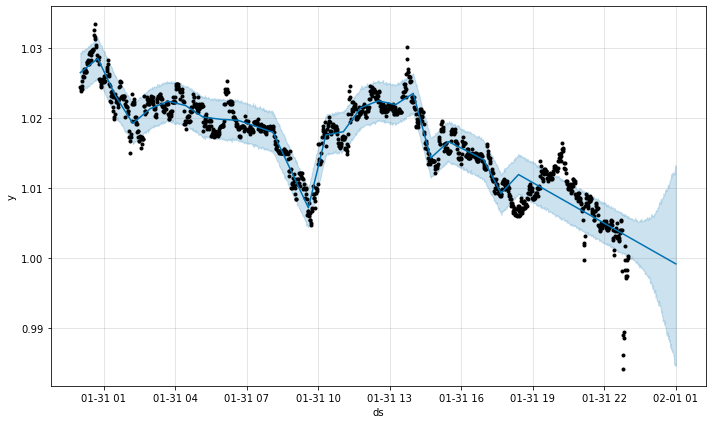

In [15]:
# 만들어진 데이터를 확인합니다.
fig1 = prophet.plot(forecast_data)

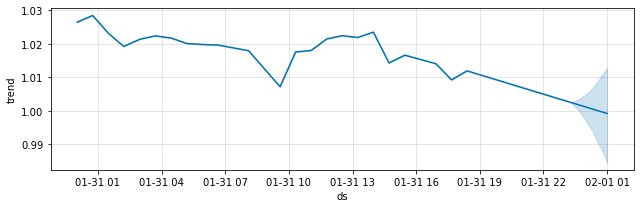

In [16]:
# 데이터의 추세를 확인합니다.
fig2 = prophet.plot_components(forecast_data)

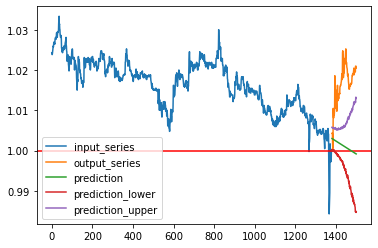

In [17]:
pred_y = forecast_data.yhat.values[-120:]
pred_y_lower = forecast_data.yhat_lower.values[-120:]
pred_y_upper = forecast_data.yhat_upper.values[-120:]

plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), pred_y, label = 'prediction')
plt.plot(np.arange(1380, 1380+120), pred_y_lower, label = 'prediction_lower')
plt.plot(np.arange(1380, 1380+120), pred_y_upper, label = 'prediction_upper')
plt.legend()
plt.show()

## 2) validation set 훈련하기

### <1> validation 데이터 생성하기

In [18]:
# train 데이터 상단의 300개 샘플로 validation set를 구성하여 학습 및 추론
valid_x_df = train_x_df[train_x_df.sample_id < 300]
valid_y_df = train_y_df[train_y_df.sample_id < 300]

valid_x_array = df2d_to_array3d(valid_x_df)
valid_y_array = df2d_to_array3d(valid_y_df)
valid_pred_array = np.zeros([300, 120])

### <2> 학습 및 추론하기

In [ ]:

for idx in tqdm(range(valid_x_array.shape[0])):
    try:
        x_series = valid_x_array[idx,:,1]

        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()

        prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=False,
                  weekly_seasonality=False, daily_seasonality=False)
        prophet.fit(x_df)

        # 120분 테스트 데이터를 예측합니다.
        future_data = prophet.make_future_dataframe(periods=120, freq='min')
        forecast_data = prophet.predict(future_data)

        pred_y = forecast_data.yhat.values[-120:]
        pred_y_lower = forecast_data.yhat_lower.values[-120:]
        pred_y_upper = forecast_data.yhat_upper.values[-120:]

        valid_pred_array[idx,:] = pred_y
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

 59%|███████████████████████████████████████████████▏                                | 177/300 [24:46<29:07, 14.21s/it]

### <3> valid_pred_array 로부터 buy_quantity, sell_time 구하기

In [ ]:
def array_to_submission(x_array, pred_array):
    # 입력 x_arrry와 출력 pred_arry를 통해서 
    # buy_quantitiy와 sell_time을 결정
    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 0.1
    
    buy_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])
    buy_price = np.array(buy_price)
    # 115% 이상 상승한하고 예측한 sample에 대해서만 100% 매수
    submission.loc[:, 'buy_quantity'] = (buy_price > 1.15) * 1
    # 모델이 예측값 중 최대 값에 해당하는 시간에 매도
    submission['sell_time'] = np.argmax(pred_array, axis = 1)
    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    return submission

In [ ]:
valid_submission = array_to_submission(valid_x_array, valid_pred_array)

In [ ]:
valid_submission

In [ ]:
# 전체 300가지 sample에 대해
# 5가지 case에서 115% 이상 상승한다고 추론함.
valid_submission.buy_quantity.value_counts()

### <4> 투자 후 금액 계산하기

In [ ]:
def df2d_to_answer(df_2d):
    # valid_y_df로부터
    # open 가격 정보가 포함된
    # [샘플 수, 120분] 크기의 
    # 2차원 array를 반환하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    sample_index = list(sample_index)
    return array_2d, sample_index


def COIN(y_df, submission, df2d_to_answer = df2d_to_answer):
    # 2차원 데이터프레임에서 open 시점 데이터만 추출하여 array로 복원
    # sample_id정보를 index에 저장
    y_array, index = df2d_to_answer(y_df)
    
    # index 기준으로 submission을 다시 선택
    submission = submission.set_index(submission.columns[0])
    submission = submission.iloc[index, :]    
    
    # 초기 투자 비용은 10000 달러
    total_momey      = 10000 # dolors
    total_momey_list = []
    
    # 가장 처음 sample_id값
    start_index = submission.index[0]
    for row_idx in submission.index:
        sell_time  = submission.loc[row_idx, 'sell_time']
        buy_price  = y_array[row_idx - start_index, 0]
        sell_price = y_array[row_idx - start_index, sell_time]
        buy_quantity = submission.loc[row_idx, 'buy_quantity'] * total_momey
        residual = total_momey - buy_quantity
        ratio = sell_price / buy_price
        total_momey = buy_quantity * ratio * 0.9995 * 0.9995 + residual        
        total_momey_list.append(total_momey)
        
    return total_momey, total_momey_list

In [ ]:
total_momey, total_momey_list = COIN(valid_y_df,
                                     valid_submission)

In [ ]:
# 투자 후 금액
print(total_momey)

In [ ]:
# 투자 히스토리
plt.plot(total_momey_list)
plt.title("history")
plt.show()

# 4. test 데이터 학습하고 추론하기

In [ ]:
test_pred_array = np.zeros([test_x_array.shape[0],
                           120])
for idx in tqdm(range(test_x_array.shape[0])):
    try:
        x_series = test_x_array[idx,:,1]

        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()

        prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=False,
                  weekly_seasonality=False, daily_seasonality=False)
        prophet.fit(x_df)

        # 120분 테스트 데이터를 예측합니다.
        future_data = prophet.make_future_dataframe(periods=120, freq='min')
        forecast_data = prophet.predict(future_data)

        pred_y = forecast_data.yhat.values[-120:]
        pred_y_lower = forecast_data.yhat_lower.values[-120:]
        pred_y_upper = forecast_data.yhat_upper.values[-120:]

        test_pred_array[idx,:] = pred_y
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

## 추론한 test_pred_array를 바탕으로 submission df 생성하기

In [ ]:
submission = array_to_submission(test_x_array, test_pred_array)

In [ ]:
submission.to_csv(data_path+"/baseline_submission_proh.csv", index = False)